In this notebook we want to explore the consumption data provided. This is the key data from which we'll design a target variable. Before committing to any specification we need understand how consumption levels trend over time. Specifically, we want to explore whether or not there exists any ramp-up phenomonon.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir_june = '/Users/briandalessandro/Downloads/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
consumption_file= 'CB_Innovation_Lab_Consumption_Data_to_end_of_Jan_2019.csv'

In [417]:
consumption_dtype = {'Customer.ID':'string', 'Date':'string', 'Hour':'string', 'Minute':'string', 
                     'Consumption.kWh':'float64','voltage_min':'float64', 'voltage_avg':'float64', 
                     'voltage_max':'float64', 'current_max':'float64',
                     'Developer_code':'category', 'Village_code':'category'
}


cons_df = pd.read_csv(data_dir_june + consumption_file)

/Users/briandalessandro/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [418]:
cons_df.head()

,Customer.ID,Date,Hour,Minute,Consumption.kWh,voltage_min,voltage_avg,voltage_max,current_max,Developer_code,Village_code
0,SM20R-03-00001085,2018-12-03,15.0,0.0,0.008937,225.92,228.925,230.87,0.084,2,6.0
1,SM20R-03-000010A4,2019-01-19,5.0,0.0,0.000875,228.96,229.345,229.67,0.020,2,6.0
2,SM20R-03-00001085,2018-12-03,14.0,0.0,0.012156,225.10,228.980,230.70,0.246,2,6.0
3,SM20R-03-00001085,2018-12-03,12.0,0.0,0.013219,228.34,228.950,229.40,0.248,2,6.0
4,SM20R-03-00001085,2018-12-03,13.0,0.0,0.009281,228.39,228.985,229.62,0.144,2,6.0


Let's explore many different metrics:
- number of entries & unique costomers per day
- total consumption by day
- avg consumption per hh by day
- avg consumption per hh by tenure day

In [420]:
#lets do an aggregation first by date/customer.ID then to date

keep_fields = ['Date','Customer.ID','Consumption.kWh']

day_cust_df = cons_df[keep_fields].groupby(['Date','Customer.ID']).agg([len,sum]).reset_index()
day_cust_df.columns = ['Date','Customer.ID','EntryCnt','Consumption.kWh']
day_cust_df['Date'] = pd.to_datetime(day_cust_df['Date'])


#Get first day and join back
first_day_df = day_cust_df[['Customer.ID','Date']].groupby(['Customer.ID']).min().reset_index()
first_day_df.rename({'Date':'First_Date'}, axis=1, inplace=True)
day_cust_df = day_cust_df.merge(first_day_df, on='Customer.ID')
day_cust_df['Tenure'] = (day_cust_df['Date'] - day_cust_df['First_Date']).dt.days

day_df = day_cust_df[['Date','Customer.ID','EntryCnt','Consumption.kWh']].groupby(['Date']).agg([len,sum]).reset_index()
day_df.columns = ['Date','Unique_Customers','Total_Entries','Dupe','Consumption.kWh']
day_df = day_df.drop('Dupe', axis=1)

day_df.sort_values(by='Date', inplace=True)

day_df.head()

,Date,Unique_Customers,Total_Entries,Consumption.kWh
0,2016-12-31,28.0,28.0,290.770000
1,2017-01-01,923.0,21027.0,151.821994
2,2017-01-02,923.0,21991.0,119.077501
3,2017-01-03,923.0,21984.0,117.103429
4,2017-01-04,918.0,21911.0,115.889500


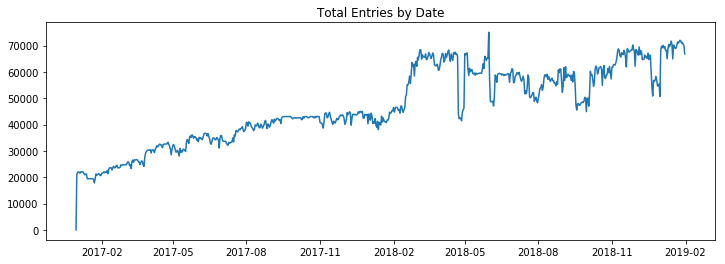

In [421]:
fig = plt.figure(figsize=(12,4))
plt.title('Total Entries by Date')
plt.plot(day_df.Date, day_df.Total_Entries)

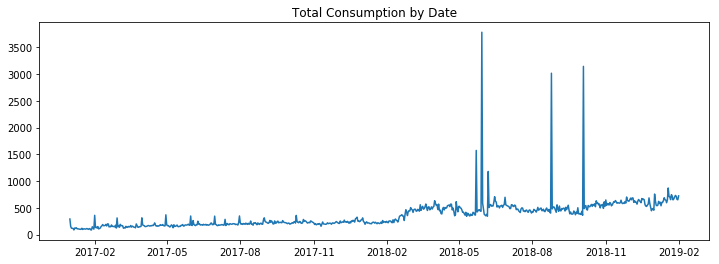

In [422]:
fig = plt.figure(figsize=(12,4))
plt.title('Total Consumption by Date')
plt.plot(day_df.Date, day_df['Consumption.kWh'])

We see some weirdly spikey behavior. Some of it could be normal, but there are some significantly outlier peaks to think about.

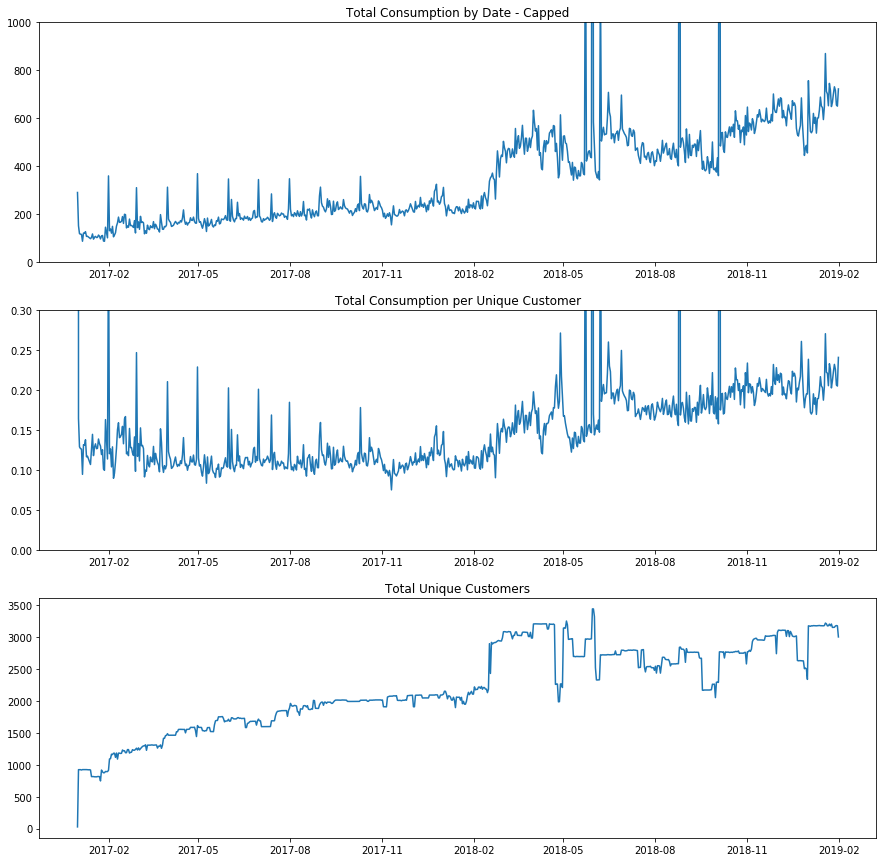

In [423]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3,1,1)
plt.title('Total Consumption by Date - Capped')
plt.plot(day_df.Date, day_df['Consumption.kWh'])
plt.ylim([0,1000])

ax2 = fig.add_subplot(3,1,2)
plt.title('Total Consumption per Unique Customer')
plt.plot(day_df.Date, day_df['Consumption.kWh'] / day_df.Unique_Customers)
plt.ylim([0,0.3])


ax3 = fig.add_subplot(3,1,3)
plt.title('Total Unique Customers')
plt.plot(day_df.Date, day_df.Unique_Customers)



Now let's look at it from where each customer started off.

In [424]:
tenure_df = day_cust_df[['Customer.ID','Consumption.kWh','Tenure']].groupby(['Tenure']).agg([sum, len]).reset_index()
tenure_df.columns = ['Tenure','Consumption.kWh','Customers']

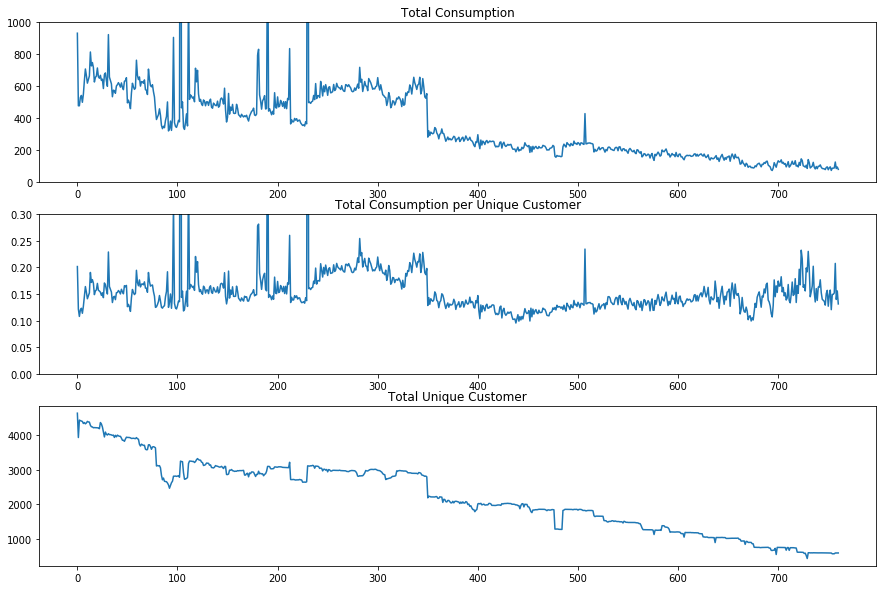

In [425]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(3,1,1)
plt.title('Total Consumption')
plt.plot(tenure_df.Tenure, tenure_df['Consumption.kWh'])
plt.ylim([0,1000])

ax2 = fig.add_subplot(3,1,2)
plt.title('Total Consumption per Unique Customer')
plt.plot(tenure_df.Tenure, tenure_df['Consumption.kWh'] / tenure_df.Customers)
plt.ylim([0,0.3])


ax3 = fig.add_subplot(3,1,3)
plt.title('Total Unique Customer')
plt.plot(tenure_df.Tenure, tenure_df.Customers)
#plt.ylim([0,1000])



In [427]:
day_cust_df[filt]['Consumption.kWh'].describe()

count    2999.000000
mean        0.240939
std         0.858509
min         0.000000
25%         0.012125
50%         0.062344
75%         0.214531
max        34.479281
Name: Consumption.kWh, dtype: float64

Example of outlier behavior by an individual hh

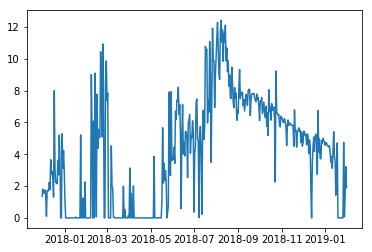

In [428]:
filt2 = (day_cust_df['Customer.ID']=='SM60R-01-0000155A')
df2 = day_cust_df[filt2]
df2 = df2.sort_values(by='Date')
df2.head()
plt.plot(df2.Date, df2['Consumption.kWh'])

In [429]:

day_cust_df[(day_cust_df['Date']=='2018-10-04') & (day_cust_df['Consumption.kWh']>5)].shape,day_cust_df[(day_cust_df['Date']=='2018-10-01') & (day_cust_df['Consumption.kWh']>5)].shape

((162, 6), (3, 6))

In [430]:
day_df[(day_df['Consumption.kWh']>1000) & (day_df['Date']>'2018-08-01')]['Date'].values

array(['2018-08-25T00:00:00.000000000', '2018-10-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Just look at period post 7/1/2018

In [431]:
capped_df = day_cust_df[(day_cust_df['Date']>'2017-01-31')]
capped_grp = capped_df[['Date','Consumption.kWh']].groupby(['Date']).quantile(q=[0.1,0.25,0.5,0.75,0.9,0.99]).reset_index()


Text(0.5,1,'Mean and Quantiles of Consumption per Capita')

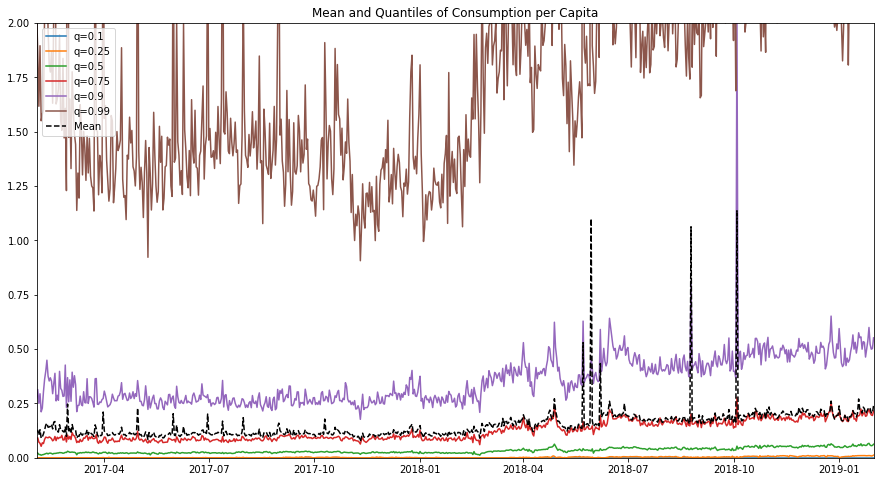

In [434]:
fig = plt.figure(figsize=(15,8))
for q in [0.1,0.25,0.5,0.75,0.9,0.99]:
    f = (capped_grp.level_1==q)
    plt.plot(capped_grp[f].Date, capped_grp[f]['Consumption.kWh'], label='q={}'.format(q))
    
plt.plot(day_df.Date, day_df['Consumption.kWh'] / day_df.Unique_Customers, 'k--',label='Mean')

plt.legend(loc=2)
plt.ylim([0,2])
plt.xlim(['2017-02-01','2019-01-31'])

plt.title('Mean and Quantiles of Consumption per Capita')

## Some observations
- the mean tends to follow the 75th quantile
- the very large outlier spikes are driving by the >99th percentile
- there is a lot of mass close to 0
- we tend to have the most stability after 6/2018, in terms of total customers and consumption / customer

## Target Option 1

Let's use the last 6 months of data, 2018-08-01 through 2019-01-31, avg daily consumption, with outliers removed

In [476]:
'''
Code to create final consumption data set

'''
data_dir_june = '/Users/briandalessandro/Downloads/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
consumption_file= 'CB_Innovation_Lab_Consumption_Data_to_end_of_Jan_2019.csv'

consumption_dtype = {'Customer.ID':'category', 'Date':'category', 'Hour':'category', 'Minute':'category', 
                     'Consumption.kWh':'float64','voltage_min':'float64', 'voltage_avg':'float64', 
                     'voltage_max':'float64', 'current_max':'float64',
                     'Developer_code':'category', 'Village_code':'category'
}


start_date = '2018-08-01'



cons_df = pd.read_csv(data_dir_june + consumption_file)

keep_fields = ['Date','Customer.ID','Consumption.kWh']

group1_df = cons_df[keep_fields].groupby(['Date','Customer.ID']).agg([sum]).reset_index()
group1_df.columns = ['Date','Customer.ID','Consumption.kWh']
group1_df['Date'] = pd.to_datetime(group1_df['Date'])

group1_df = pd.DataFrame(group1_df[(group1_df.Date>=start_date)])


#get 99th% on non-outlier days
p99_5 = np.percentile(group1_df[(group1_df.Date>'2018-10-06')]['Consumption.kWh'].values, 99.5)

#Any record > 99.5th% is capped at 99.5%
group1_df['Outlier'] = (group1_df['Consumption.kWh']>p99_5)*1
group1_df['Consumption_Adjusted'] = group1_df.Outlier*p99_5 + (1-group1_df.Outlier)*group1_df['Consumption.kWh']
group1_df['DayCnt'] = np.ones(group1_df.shape[0])

#Get grouped statistics
group2_df = group1_df[['Date','Customer.ID','Consumption.kWh','Consumption_Adjusted','DayCnt']].groupby('Customer.ID').agg([sum]).reset_index()
group2_df.columns = ['Customer.ID','Consumption','Consumption_Adjusted','DayCnt']

#Get key dates
group2_ex_df = group1_df[['Date','Customer.ID']].groupby('Customer.ID').agg([min,max]).reset_index()
group2_ex_df.columns = ['Customer.ID','First_Date','Last_Date']
group2_ex_df['Billing_Range'] = (pd.to_datetime('2019-02-01') - group2_ex_df['First_Date']).dt.days

#Group it all together

target_consumption_df = group2_df.merge(group2_ex_df, on='Customer.ID')

target_consumption_df['Avg_Consumption_Adjusted'] = target_consumption_df.Consumption_Adjusted / target_consumption_df.DayCnt
target_consumption_df['Avg_Consumption_Adjusted_ZeroPad'] = target_consumption_df.Consumption_Adjusted / target_consumption_df.Billing_Range

#Delete any that had first observations later than 10/1/2018
target_consumption_df = target_consumption_df[(target_consumption_df.First_Date<'2018-10-01')]


#Delete any that had first observations later than 10/1/2018
v = target_consumption_df.Avg_Consumption_Adjusted / target_consumption_df.Avg_Consumption_Adjusted_ZeroPad
target_consumption_noout_df = target_consumption_df[(v<5)]



target_consumption_noout_df.to_csv(data_dir_june + 'processed/target_variable.csv', index=False)



In [479]:
data_dir_june = '/Users/briandalessandro/Downloads/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
survey_data = '1_RF_Baseline_2018-07-24-FINAL.xlsx'
survey_df = pd.read_excel(data_dir_june + survey_data)

print('Total # of Customers')
print(len(cons_df['Customer.ID'].value_counts()))
print('Total # of Customers Having Consumption > 2018-08-01')
print(len(group1_df['Customer.ID'].value_counts()))
print('Total # of Customers Having Consumption > 2018-08-01 and starting before 2018-10-01')
print(len(target_consumption_df['Customer.ID'].value_counts()))
print('Total # of Customers Having Consumption > 2018-08-01 and starting before 2018-10-01 w/ Regular Consumption')
print(len(target_consumption_noout_df['Customer.ID'].value_counts()))
print('Total match with Option 1 label and in Survey')
print(len(set(target_consumption_noout_df['Customer.ID']) & set(survey_df['Meter_number'])))


Total # of Customers
4621
Total # of Customers Having Consumption > 2018-08-01
3637
Total # of Customers Having Consumption > 2018-08-01 and starting before 2018-10-01
3006
Total # of Customers Having Consumption > 2018-08-01 and starting before 2018-10-01 w/ Regular Consumption
2708
Total match with Option 1 label and in Survey
1747


## Target Option 2

Use 3-12 months for each individual, with outliers removed

In [521]:
'''
Code to create final consumption data set

'''
data_dir_june = '/Users/briandalessandro/Downloads/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
consumption_file= 'CB_Innovation_Lab_Consumption_Data_to_end_of_Jan_2019.csv'



start_date = '2017-01-01'

#cons_df = pd.read_csv(data_dir_june + consumption_file)

keep_fields = ['Date','Customer.ID','Consumption.kWh']

group1_df = cons_df[keep_fields].groupby(['Date','Customer.ID']).agg([sum]).reset_index()
group1_df.columns = ['Date','Customer.ID','Consumption.kWh']
group1_df['Date'] = pd.to_datetime(group1_df['Date'])

first_day_df = group1_df[['Customer.ID','Date']].groupby(['Customer.ID']).min().reset_index()
first_day_df.rename({'Date':'First_Date'}, axis=1, inplace=True)

group1_df = group1_df.merge(first_day_df, on='Customer.ID')
group1_df['Tenure'] = (group1_df['Date'] - group1_df['First_Date']).dt.days

#We don't trust anything before 2017
group1_df = group1_df[(group1_df.Date>=start_date)]

#Get all billings between first 90 days and 1 year
group1_df = group1_df[(group1_df.Tenure>90) & (group1_df.Tenure<=365)]

#Get min/max billing dates within this range
group1_min_max = group1_df[['Customer.ID','Date']].groupby(['Customer.ID']).agg([min,max]).reset_index()
group1_min_max.columns = ['Customer.ID', 'start_date','end_date']

#Get total usage
group1_agg = group1_df[['Customer.ID','Consumption.kWh']].groupby(['Customer.ID']).sum().reset_index()
group1_agg = group1_agg.merge(group1_min_max, on='Customer.ID')
group1_agg['Days'] = (group1_agg['end_date'] - group1_agg['start_date']).dt.days + 1
group1_agg['avg_consumption'] = group1_agg['Consumption.kWh'] / group1_agg['Days']

print("Pre-outlier scrubbing")
print(group1_agg.shape[0])
print("Post-outlier scrubbing")
group1_agg = group1_agg[(group1_agg.avg_consumption<5)]
print(group1_agg.shape[0])


Pre-outlier scrubbing
3655
Post-outlier scrubbing
3654


In [522]:
print('Total match with Option 2 label and in Survey')
print(len(set(group1_agg['Customer.ID']) & set(survey_df['Meter_number'])))

Total match with Option 2 label and in Survey
2114


In [525]:
group1_agg[['Customer.ID','start_date','end_date','avg_consumption']] \
    .to_csv(data_dir_june + 'processed/target_variable_tenure.csv', index=False)